# Importing Modules

In [1]:
# Cleanning
import pandas as pd
import numpy as np
from scipy.stats import mode

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Modelling
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import (StandardScaler, MinMaxScaler)
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from scipy.stats import iqr
from scipy.stats import scoreatpercentile as pct
from sklearn.cluster import KMeans
from scipy.stats import norm
from scipy.stats import probplot


 # Units

In [2]:
sqft_to_sqm = (0.3048)**2

# Functions

## Data Cleaning Pipeline Functions

### Importing Data

In [3]:
def load_data(file):

    path = "Data/" + file

    file1 = pd.read_excel(path)

    return file1

### Standardizing Headings

In [4]:
def standard_headings(df):
    """
    Returns a Pandas Dataframe with an standarized heading, i.e lower case and " " replaced by "_"
    
    Parameters
    ----------
    columns_list : Pandas Dataframe

    Returns
    -------
    Returns a Pandas Dataframe with an standarized heading, i.e lower case and " " replaced by "_"

    """  
    heading = df.columns
    df.columns = [clabel.lower().replace(" ", "_") for clabel in heading]
    return df


## Transform yr_built into age

In [5]:
def transform_age(df):

    df["yr_built"] = max(df["yr_built"]) - df["yr_built"]
    df = df.rename(columns={"yr_built":"age"})

    return df

## Transform yr_built into age

In [6]:
def transform_renovated(df):

    df["yr_renovated"] = df["yr_renovated"].where(df["yr_renovated"] == 0, other=1)
    df = df.rename(columns={"yr_renovated":"renovated"})

    return df

### Converting to Categorical Type

In [7]:
def obj_to_cat(df, columns_list):

    for column in columns_list:

        df[column] = df[column].astype("category")

    return df

### Removing specific rows

In [8]:
def remove_rows(df):

    df = df[df["bedrooms"] != 33]

    return df

## Regression Functions

In [88]:
def my_transformations(df, test_size=0.2, scaler = "standard"):

    # x-y split

    X = df.drop("price", axis=1)
    y = df["price"]

    # Train/Test Split
    X_train, X_test, y_train, y_test=train_test_split(X, y, test_size= test_size, random_state=0)
    
    
    # Numerical and categorical variables

    X_train_num = X_train._get_numeric_data()
    X_test_num = X_test._get_numeric_data()
    X_train_cat = X_train.select_dtypes("category")
    X_test_cat = X_test.select_dtypes("category")

    # Numerical Variables Scaling
    
    if scaler == "minmax":
    
        scaler = MinMaxScaler()

    elif scaler == "standard":

        scaler = StandardScaler()
    
    scaler.fit(X_train_num)
    X_train_num_scaled = pd.DataFrame(scaler.transform(X_train_num), columns=X_train_num.columns).reset_index(drop=True)
    X_test_num_scaled = pd.DataFrame(scaler.transform(X_test_num), columns=X_test_num.columns).reset_index(drop=True)
    
    return {"train":[X_train_num_scaled, X_train_cat, y_train], "test":[X_test_num_scaled, X_test_cat, y_test]}

In [91]:
def my_linear_regression(X_train, y_train, X_test, y_test):

    # Linear Regression
    model = LinearRegression()
    model.fit(X_train, y_train)
    coefficients = list(model.coef_)

    # Predict
    y_pred = model.predict(X_test)
    result = pd.DataFrame({"y_test":y_test, "y_pred":y_pred})

    # Metrics
    
    R2 = r2_score(y_test, y_pred)
    metrics = {"MSE":mse(y_test, y_pred), "RMSE":mse(y_test, y_pred, squared=False), "MAE":mae(y_test, y_pred), "R2":R2, "R2_adj":R2_adjusted(X_test, y_test, y_pred, R2)}

    # Plots

    fig, axs = plt.subplots(1,3,figsize=(30,10))

    sns.regplot(x="y_test", y="y_pred", data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"}, ax=axs[0])
    sns.histplot(y_test-y_pred, kde=True, ax=axs[1])
    axs[2].plot(y_pred,y_test - y_pred,"o")
    axs[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')

    axs[0].set_title("Test Set - Observed VS Predicted")
    axs[1].set_title("Test Set - Histogram of the Residuals")
    axs[1].set_xlabel("y_test - y_pred")
    axs[2].set_xlabel("predited")
    axs[2].set_ylabel("residuals")
    axs[2].set_title("Residuals by Predicted")
    


    # Output
    
    return {"Fitting Coefficients":coefficients, "Result":result, "Metrics":metrics, "Figure": (fig, axs)}

## Utility Functions

In [9]:
# Function to store in dictionary the number of nan values per column

def nan_counter(df):
    
    """
    Returns a dictionary containing the number of nan values per column (for dataframe df)

    Parameters
    ----------
    df : Pandas dataframe

    Returns
    -------
    remaining_nan : Dictionary
        Contains the number of nan values in each column of the dataframe

    """
    
    remaining_nan = {}

    for column in df.columns:

        remaining_nan[column] = df[column][df[column].isna() == True].size

    return remaining_nan

In [99]:
def R2_adjusted(X, y, y_pred, R2=None):
    
    if R2==None:
    
        R2 = r2_score(y, y_pred)
    
    else:
        R2_adj = 1 - (1-R2)*(len(y)-1)/(len(y)-X.shape[1]-1)

    return R2_adj

# Pipeline Controller

In [10]:
# Inputs for the Pipeline Controller

drop_columns = ["id", "date","sqft_lot", "sqft_above", "sqft_basement", "sqft_lot15", "condition"]
# bucket_columns = ["st", "gender"]
# clean_columns_NaN = ["customer_lifetime_value", "income", "monthly_premium_auto", "number_of_open_complaints", "total_claim_amount"]
# clean_columns_zeros = ["income"]
# clean_columns_cat = [("gender", "U")]
# int_columns = ["customer_lifetime_value", "income", "monthly_premium_auto", "number_of_open_complaints", "total_claim_amount"]
cat_columns = ['waterfront', 'view', 'grade', 'renovated']

# bucketing_dict = {"F":"F", "female":"F", "Femal":"F"
#                  ,"M":"M", "Male":"M"
#                  ,"California": "California", "Cali": "California"
#                  ,"Arizona":"Arizona","AZ":"Arizona"
#                  ,"Washington":"Washington", "WA":"Washington"
#                  ,"Oregon":"Oregon"
#                  ,"Nevada":"Nevada"
#                  ,np.nan:np.nan
#                  }

In [68]:
hp_df = (load_data("Data_MidTerm_Project_Real_State_Regression.xls")
.pipe(standard_headings)
.drop(drop_columns, axis=1)
.pipe(transform_age)
.pipe(transform_renovated)
# .pipe(dt_corrector)
# .pipe(bucket_series, bucket_columns, bucketing_dict)
# .drop_duplicates().reset_index(drop=True)
# .pipe(replace_by, clean_columns_NaN)
# .pipe(replace_by, clean_columns_zeros)
# .pipe(replace_by_cat, clean_columns_cat)
# .dropna()
# .pipe(standardize_data)
# .pipe(float_to_int, float_columns)
.pipe(obj_to_cat, cat_columns)
.pipe(remove_rows)
)

In [12]:
hp_df

,bedrooms,bathrooms,sqft_living,floors,waterfront,view,grade,age,renovated,zipcode,lat,long,sqft_living15,price
0,3,1.00,1180,1.0,0,0,7,60,0,98178,47.5112,-122.257,1340,221900
1,3,2.25,2570,2.0,0,0,7,64,1,98125,47.7210,-122.319,1690,538000
2,2,1.00,770,1.0,0,0,6,82,0,98028,47.7379,-122.233,2720,180000
3,4,3.00,1960,1.0,0,0,7,50,0,98136,47.5208,-122.393,1360,604000
4,3,2.00,1680,1.0,0,0,8,28,0,98074,47.6168,-122.045,1800,510000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,3,2.50,1530,3.0,0,0,8,6,0,98103,47.6993,-122.346,1530,360000
21593,4,2.50,2310,2.0,0,0,8,1,0,98146,47.5107,-122.362,1830,400000
21594,2,0.75,1020,2.0,0,0,7,6,0,98144,47.5944,-122.299,1020,402101
21595,3,2.50,1600,2.0,0,0,8,11,0,98027,47.5345,-122.069,1410,400000


# Initial Data Exploration

In [13]:
hp_df = (load_data("Data_MidTerm_Project_Real_State_Regression.xls")
.pipe(standard_headings)
)

In [14]:
hp_df

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,7129300520,2014-10-13,3,1.00,1180,5650,1.0,0,0,3,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900
1,6414100192,2014-12-09,3,2.25,2570,7242,2.0,0,0,3,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000
2,5631500400,2015-02-25,2,1.00,770,10000,1.0,0,0,3,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000
3,2487200875,2014-12-09,4,3.00,1960,5000,1.0,0,0,5,...,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000
4,1954400510,2015-02-18,3,2.00,1680,8080,1.0,0,0,3,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,2014-05-21,3,2.50,1530,1131,3.0,0,0,3,...,1530,0,2009,0,98103,47.6993,-122.346,1530,1509,360000
21593,6600060120,2015-02-23,4,2.50,2310,5813,2.0,0,0,3,...,2310,0,2014,0,98146,47.5107,-122.362,1830,7200,400000
21594,1523300141,2014-06-23,2,0.75,1020,1350,2.0,0,0,3,...,1020,0,2009,0,98144,47.5944,-122.299,1020,2007,402101
21595,291310100,2015-01-16,3,2.50,1600,2388,2.0,0,0,3,...,1600,0,2004,0,98027,47.5345,-122.069,1410,1287,400000


In [15]:
hp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21597 non-null  int64         
 1   date           21597 non-null  datetime64[ns]
 2   bedrooms       21597 non-null  int64         
 3   bathrooms      21597 non-null  float64       
 4   sqft_living    21597 non-null  int64         
 5   sqft_lot       21597 non-null  int64         
 6   floors         21597 non-null  float64       
 7   waterfront     21597 non-null  int64         
 8   view           21597 non-null  int64         
 9   condition      21597 non-null  int64         
 10  grade          21597 non-null  int64         
 11  sqft_above     21597 non-null  int64         
 12  sqft_basement  21597 non-null  int64         
 13  yr_built       21597 non-null  int64         
 14  yr_renovated   21597 non-null  int64         
 15  zipcode        2159

In [16]:
hp_df.describe()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,2.159700e+04
mean,4.580474e+09,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007547,0.234292,3.409825,7.657915,1788.596842,291.725008,1970.999676,84.464787,98077.951845,47.560093,-122.213982,1986.620318,12758.283512,5.402966e+05
std,2.876736e+09,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086549,0.766390,0.650546,1.173200,827.759761,442.667800,29.375234,401.821438,53.513072,0.138552,0.140724,685.230472,27274.441950,3.673681e+05
min,1.000102e+06,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,7.800000e+04
25%,2.123049e+09,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000,3.220000e+05
50%,3.904930e+09,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000,4.500000e+05
75%,7.308900e+09,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000,6.450000e+05
max,9.900000e+09,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,7.700000e+06


In [17]:
hp_df_shape = hp_df.shape
hp_df_shape

(21597, 21)

In [18]:
nan_counter(hp_df)

{'id': 0,
 'date': 0,
 'bedrooms': 0,
 'bathrooms': 0,
 'sqft_living': 0,
 'sqft_lot': 0,
 'floors': 0,
 'waterfront': 0,
 'view': 0,
 'condition': 0,
 'grade': 0,
 'sqft_above': 0,
 'sqft_basement': 0,
 'yr_built': 0,
 'yr_renovated': 0,
 'zipcode': 0,
 'lat': 0,
 'long': 0,
 'sqft_living15': 0,
 'sqft_lot15': 0,
 'price': 0}

In [19]:
hp_df.drop_duplicates().shape

(21597, 21)

In [20]:
dep_var = hp_df["price"]

# Price Analysis

## Description and Distribution

In [21]:
# Descriptive statistics summary
dep_var.describe()

count    2.159700e+04
mean     5.402966e+05
std      3.673681e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

C:\Users\ehern\miniconda3\envs\DA_Environment\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

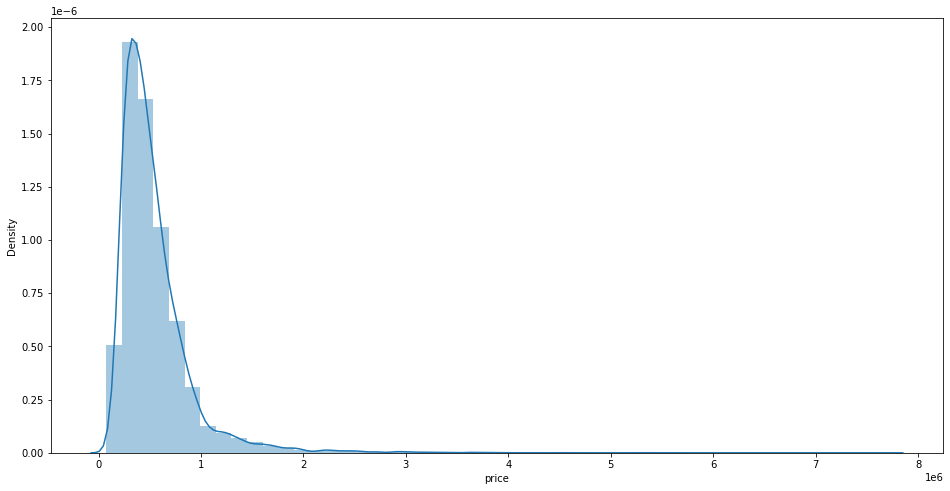

In [22]:
# Histogram

# create figure and axes
fig, ax = plt.subplots(figsize = (16,8))

sns.distplot(dep_var)

In [23]:
# Skewness and Kurtosis
print(f"Skewness: {dep_var.skew()}")
print(f"Kurtosis: {dep_var.kurt()}")

Skewness: 4.023364652271239
Kurtosis: 34.54135857673376


C:\Users\ehern\miniconda3\envs\DA_Environment\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

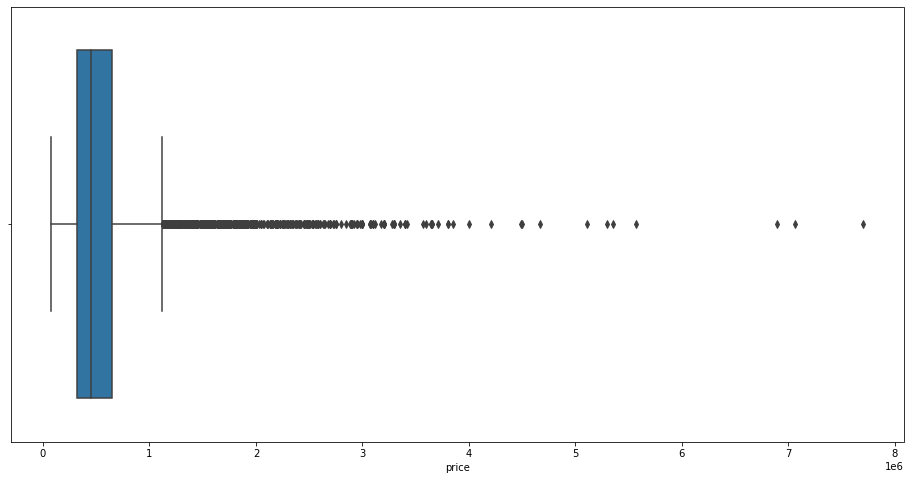

In [24]:
# Boxplot

# create figure and axes
fig, ax = plt.subplots(figsize = (16,8))

sns.boxplot(dep_var)

## Feature Correlations with Price

In [25]:
# Numerical columns and correlation matrix

num_columns = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront'
              , 'view', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'price'
              ]
hp_num_df = hp_df[num_columns]
correlation_matrix = hp_df.corr()

<AxesSubplot:title={'center':'Correlation Heatmap'}>

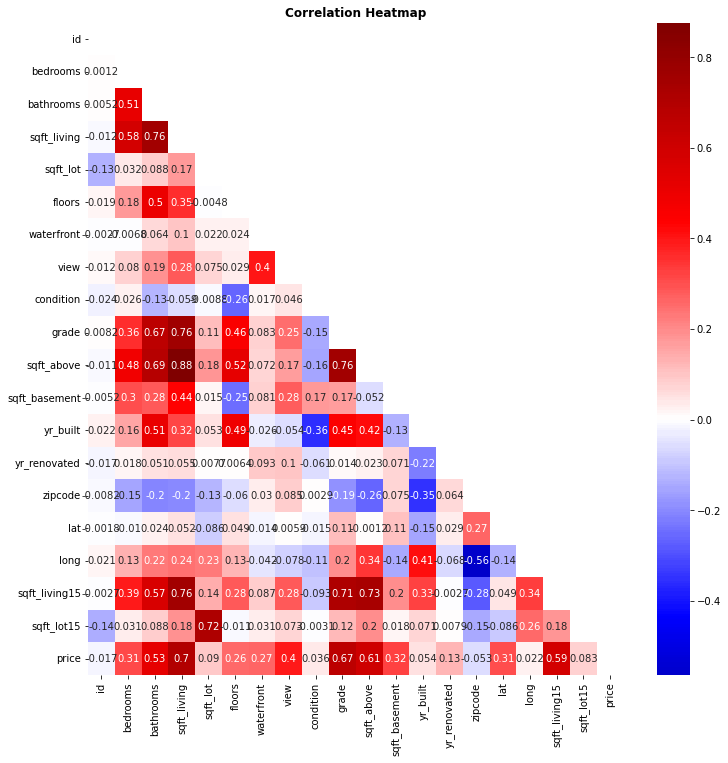

In [26]:
# Correlation Heatmap

# create figure and axes
fig, ax = plt.subplots(figsize = (12,12))

# set title
ax.set_title('Correlation Heatmap', fontweight='bold')

# mask
mask = np.zeros_like(correlation_matrix)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(correlation_matrix,  # the data for the heatmap
                          annot=True,  # show the actual values of correlation
                          cmap='seismic',  # provide the 'seismic' colormap
                          mask=mask,
                          center=0,  # specify the value at which to center the colormap
                          )

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

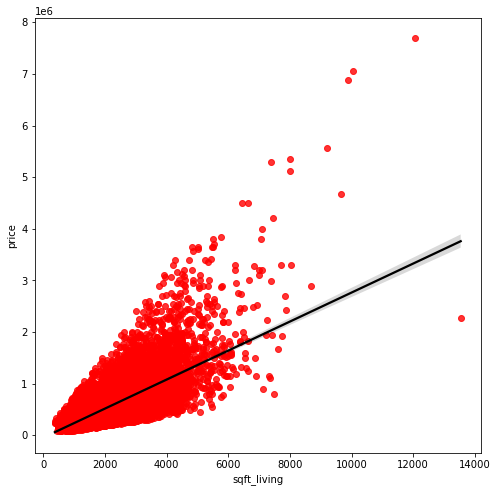

In [27]:
# Scatter plot with sqft_living
var = 'sqft_living'
data = pd.concat([dep_var, hp_df[var]], axis=1)

fig, ax = plt.subplots(figsize = (8,8))
sns.regplot(x=var, y="price", data=data, scatter_kws={"color": "red"}, line_kws={"color": "black"})


<AxesSubplot:xlabel='sqft_living15', ylabel='price'>

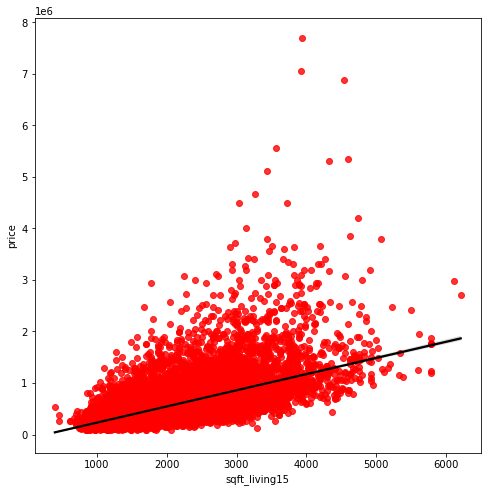

In [28]:
# Scatter plot with sqft_living15
var = 'sqft_living15'
data = pd.concat([dep_var, hp_df[var]], axis=1)

fig, ax = plt.subplots(figsize = (8,8))
sns.regplot(x=var, y="price", data=data, scatter_kws={"color": "red"}, line_kws={"color": "black"})


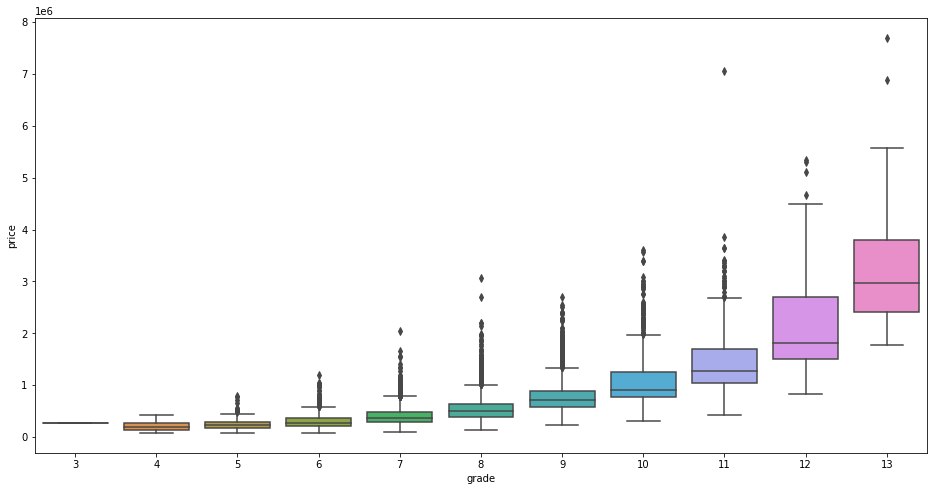

In [29]:
#box plot grade/saleprice
var = 'grade'
data = pd.concat([dep_var, hp_df[var]], axis=1)
fig, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="price", data=data)

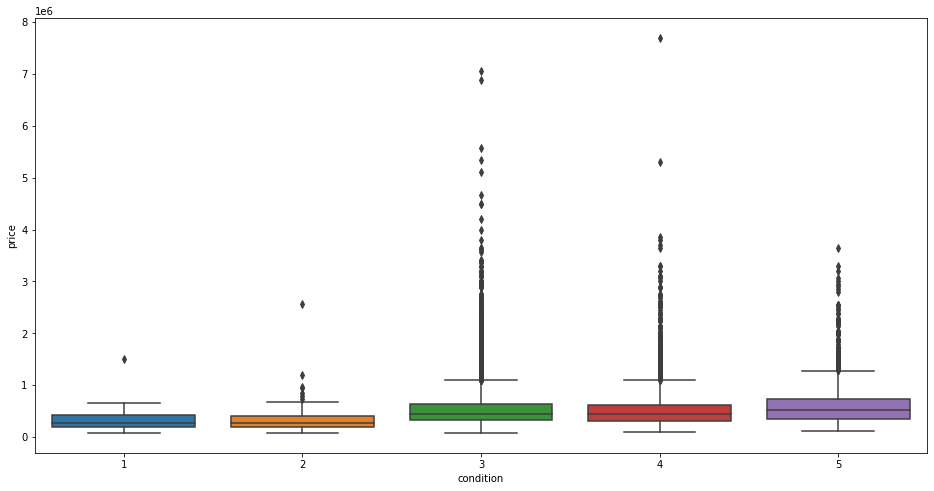

In [30]:
#box plot condition/saleprice
var = 'condition'
data = pd.concat([dep_var, hp_df[var]], axis=1)
fig, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="price", data=data)

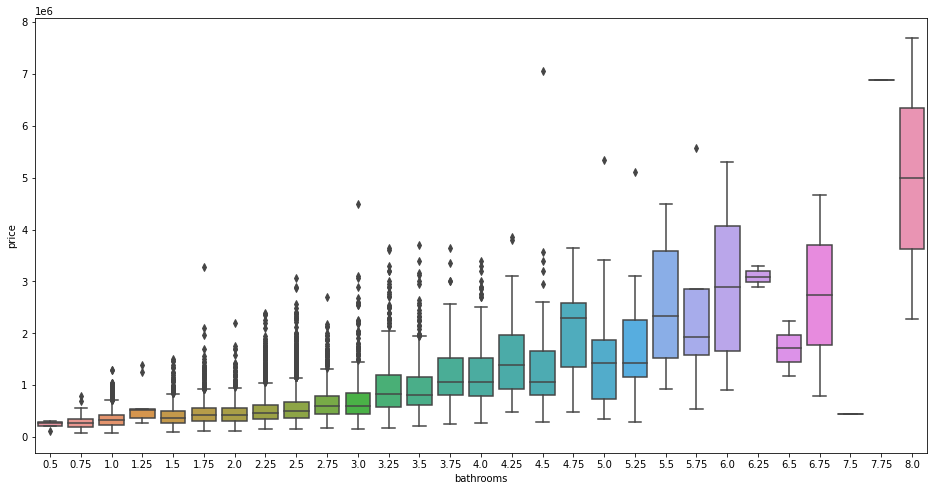

In [31]:
#box plot n bathrooms/saleprice
var = 'bathrooms'
data = pd.concat([dep_var, hp_df[var]], axis=1)
fig, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="price", data=data)

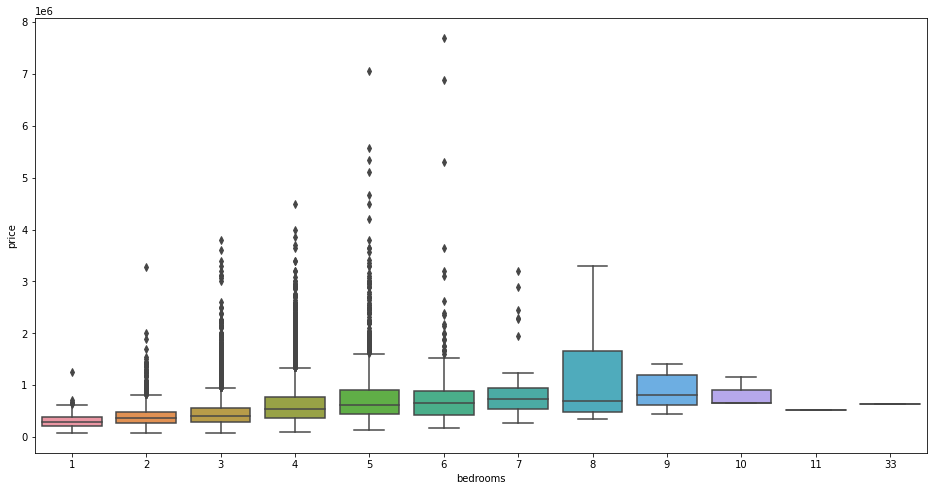

In [32]:
#box plot n bedrooms/saleprice
var = 'bedrooms'
data = pd.concat([dep_var, hp_df[var]], axis=1)
fig, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="price", data=data)

In [33]:
# Records with yr_renovated = 0

yr_renovated_n_0 = hp_df.yr_renovated.value_counts(dropna=False).sort_index()

print(f'The number of record with availabe info regarding the renovation year is {hp_df_shape[0] - yr_renovated_n_0[0]}.')


The number of record with availabe info regarding the renovation year is 914.


# Data Transformations

Let us tranform the construction year of the houses into a variable representing the age.

In [34]:
max(hp_df["yr_built"])

2015

In [35]:
hp_df["yr_built"] =  max(hp_df["yr_built"]) - hp_df["yr_built"]

In [36]:
hp_df = hp_df.rename(columns={"yr_built":"age"})

In [37]:
hp_df

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,age,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,7129300520,2014-10-13,3,1.00,1180,5650,1.0,0,0,3,...,1180,0,60,0,98178,47.5112,-122.257,1340,5650,221900
1,6414100192,2014-12-09,3,2.25,2570,7242,2.0,0,0,3,...,2170,400,64,1991,98125,47.7210,-122.319,1690,7639,538000
2,5631500400,2015-02-25,2,1.00,770,10000,1.0,0,0,3,...,770,0,82,0,98028,47.7379,-122.233,2720,8062,180000
3,2487200875,2014-12-09,4,3.00,1960,5000,1.0,0,0,5,...,1050,910,50,0,98136,47.5208,-122.393,1360,5000,604000
4,1954400510,2015-02-18,3,2.00,1680,8080,1.0,0,0,3,...,1680,0,28,0,98074,47.6168,-122.045,1800,7503,510000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,2014-05-21,3,2.50,1530,1131,3.0,0,0,3,...,1530,0,6,0,98103,47.6993,-122.346,1530,1509,360000
21593,6600060120,2015-02-23,4,2.50,2310,5813,2.0,0,0,3,...,2310,0,1,0,98146,47.5107,-122.362,1830,7200,400000
21594,1523300141,2014-06-23,2,0.75,1020,1350,2.0,0,0,3,...,1020,0,6,0,98144,47.5944,-122.299,1020,2007,402101
21595,291310100,2015-01-16,3,2.50,1600,2388,2.0,0,0,3,...,1600,0,11,0,98027,47.5345,-122.069,1410,1287,400000


We transform also the renovation year into a binary variable representing if the house has been renovated or not.

In [38]:
hp_df["yr_renovated"] = hp_df["yr_renovated"].where(hp_df["yr_renovated"]==0, other=1)

In [39]:
hp_df["yr_renovated"].value_counts()

0    20683
1      914
Name: yr_renovated, dtype: int64

In [40]:
hp_df = hp_df.rename(columns={"yr_renovated":"renovated"})

In [41]:
hp_df = hp_df[hp_df["bedrooms"] != 33]

In [42]:
hp_df

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,age,renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,7129300520,2014-10-13,3,1.00,1180,5650,1.0,0,0,3,...,1180,0,60,0,98178,47.5112,-122.257,1340,5650,221900
1,6414100192,2014-12-09,3,2.25,2570,7242,2.0,0,0,3,...,2170,400,64,1,98125,47.7210,-122.319,1690,7639,538000
2,5631500400,2015-02-25,2,1.00,770,10000,1.0,0,0,3,...,770,0,82,0,98028,47.7379,-122.233,2720,8062,180000
3,2487200875,2014-12-09,4,3.00,1960,5000,1.0,0,0,5,...,1050,910,50,0,98136,47.5208,-122.393,1360,5000,604000
4,1954400510,2015-02-18,3,2.00,1680,8080,1.0,0,0,3,...,1680,0,28,0,98074,47.6168,-122.045,1800,7503,510000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,2014-05-21,3,2.50,1530,1131,3.0,0,0,3,...,1530,0,6,0,98103,47.6993,-122.346,1530,1509,360000
21593,6600060120,2015-02-23,4,2.50,2310,5813,2.0,0,0,3,...,2310,0,1,0,98146,47.5107,-122.362,1830,7200,400000
21594,1523300141,2014-06-23,2,0.75,1020,1350,2.0,0,0,3,...,1020,0,6,0,98144,47.5944,-122.299,1020,2007,402101
21595,291310100,2015-01-16,3,2.50,1600,2388,2.0,0,0,3,...,1600,0,11,0,98027,47.5345,-122.069,1410,1287,400000


There is one record with 33 rooms that is obviously a typo. We will remove this row.

In [43]:
hp_df["floors"].value_counts()

1.0    10672
2.0     8235
1.5     1910
3.0      611
2.5      161
3.5        7
Name: floors, dtype: int64

In [44]:
hp_df.columns

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'age', 'renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'price'],
      dtype='object')

In [45]:
['waterfront', 'view', 'grade', 'age', 'renovated']

['waterfront', 'view', 'grade', 'age', 'renovated']

In [46]:
hp_df[hp_df["bathrooms"] == 7.5]

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,age,renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
8537,424049043,2014-08-11,9,7.5,4050,6504,2.0,0,0,3,...,4050,0,19,0,98144,47.5923,-122.301,1448,3866,450000


In [47]:
correlation_matrix = hp_df.corr()

<AxesSubplot:title={'center':'Correlation Heatmap'}>

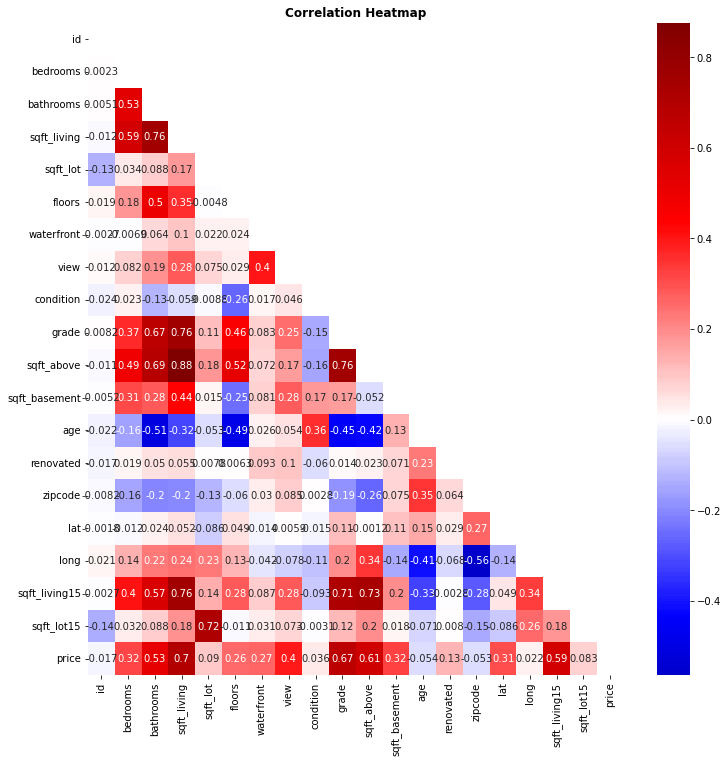

In [48]:
# Correlation Heatmap

# create figure and axes
fig, ax = plt.subplots(figsize = (12,12))

# set title
ax.set_title('Correlation Heatmap', fontweight='bold')

# mask
mask = np.zeros_like(correlation_matrix)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(correlation_matrix,  # the data for the heatmap
                          annot=True,  # show the actual values of correlation
                          cmap='seismic',  # provide the 'seismic' colormap
                          mask=mask,
                          center=0,  # specify the value at which to center the colormap
                          )

In [49]:
hp_df[hp_df["bedrooms"] == 11]

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,age,renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
8748,1773100755,2014-08-21,11,3.0,3000,4960,2.0,0,0,3,...,2400,600,97,1,98106,47.556,-122.363,1420,4960,520000


In [50]:
hp_df

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,age,renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,7129300520,2014-10-13,3,1.00,1180,5650,1.0,0,0,3,...,1180,0,60,0,98178,47.5112,-122.257,1340,5650,221900
1,6414100192,2014-12-09,3,2.25,2570,7242,2.0,0,0,3,...,2170,400,64,1,98125,47.7210,-122.319,1690,7639,538000
2,5631500400,2015-02-25,2,1.00,770,10000,1.0,0,0,3,...,770,0,82,0,98028,47.7379,-122.233,2720,8062,180000
3,2487200875,2014-12-09,4,3.00,1960,5000,1.0,0,0,5,...,1050,910,50,0,98136,47.5208,-122.393,1360,5000,604000
4,1954400510,2015-02-18,3,2.00,1680,8080,1.0,0,0,3,...,1680,0,28,0,98074,47.6168,-122.045,1800,7503,510000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,2014-05-21,3,2.50,1530,1131,3.0,0,0,3,...,1530,0,6,0,98103,47.6993,-122.346,1530,1509,360000
21593,6600060120,2015-02-23,4,2.50,2310,5813,2.0,0,0,3,...,2310,0,1,0,98146,47.5107,-122.362,1830,7200,400000
21594,1523300141,2014-06-23,2,0.75,1020,1350,2.0,0,0,3,...,1020,0,6,0,98144,47.5944,-122.299,1020,2007,402101
21595,291310100,2015-01-16,3,2.50,1600,2388,2.0,0,0,3,...,1600,0,11,0,98027,47.5345,-122.069,1410,1287,400000


# Normalization

## Price

C:\Users\ehern\miniconda3\envs\DA_Environment\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


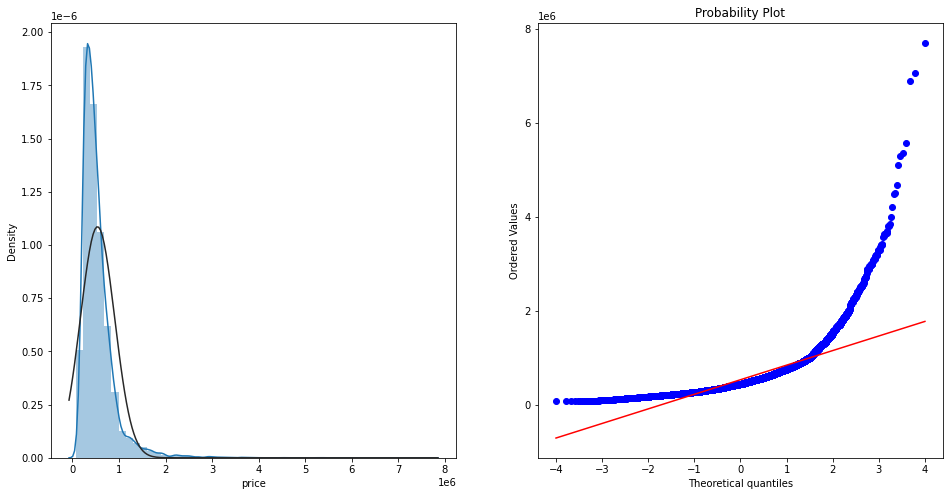

In [71]:
# create figure and axes
fig, axs = plt.subplots(1,2,figsize = (16,8))

sns.distplot(dep_var,fit=norm, ax=axs[0])
result = probplot(dep_var, plot=plt)

### Logarithmic Transformation

In [72]:
price_log_norm = np.log(dep_var)

C:\Users\ehern\miniconda3\envs\DA_Environment\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


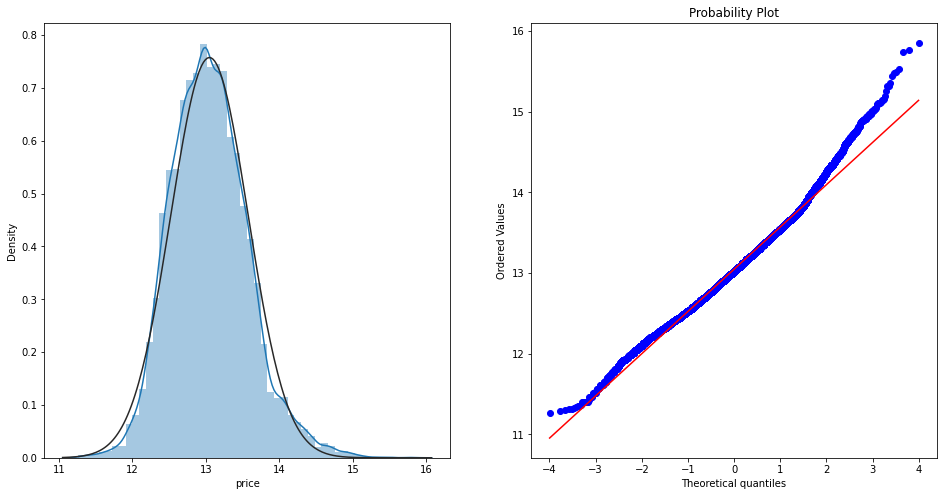

In [73]:
# create figure and axes
fig, axs = plt.subplots(1,2,figsize = (16,8))

sns.distplot(price_log_norm,fit=norm, ax=axs[0])
result = probplot(price_log_norm, plot=plt)

### Power Transformation

In [74]:
price_transformer = PowerTransformer(method="box-cox").fit(dep_var.to_numpy().reshape(-1,1))

price_power_norm = price_transformer.transform(dep_var.to_numpy().reshape(-1,1))
print(price_transformer.lambdas_)
price_power_norm = pd.DataFrame(price_power_norm)[0]

[-0.23611204]


C:\Users\ehern\miniconda3\envs\DA_Environment\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


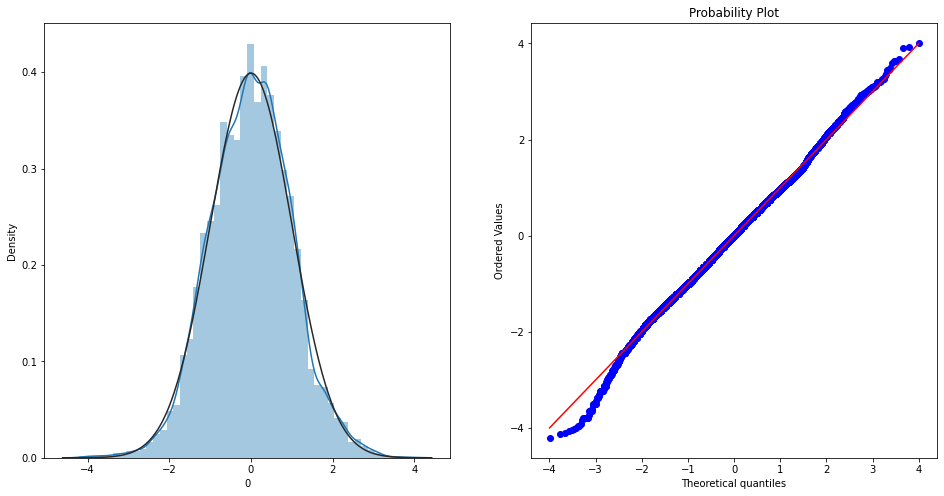

In [75]:
# create figure and axes
fig, axs = plt.subplots(1,2,figsize = (16,8))

sns.distplot(price_power_norm,fit=norm, ax=axs[0])
result = probplot(price_power_norm, plot=plt)

# sqft_living

C:\Users\ehern\miniconda3\envs\DA_Environment\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


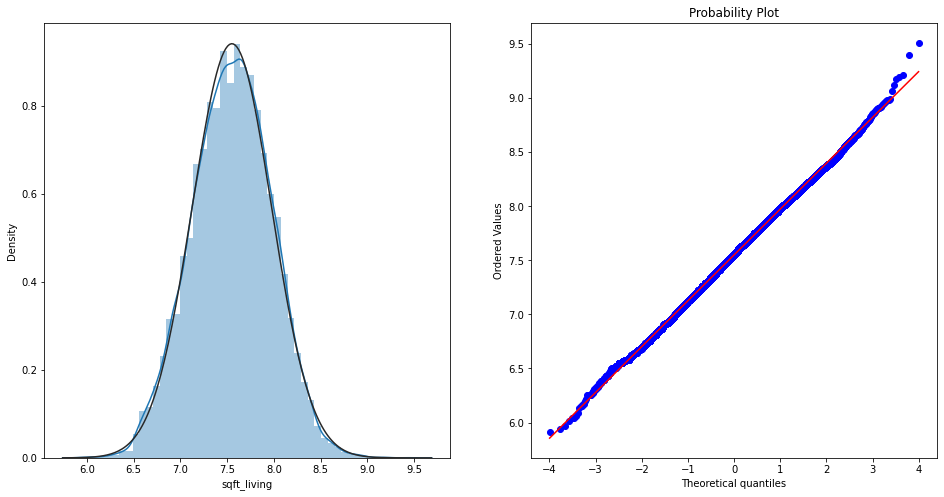

In [76]:
var = "sqft_living"

# create figure and axes
fig, axs = plt.subplots(1,2,figsize = (16,8))

sns.distplot(hp_df[var],fit=norm, ax=axs[0])
result = probplot(hp_df[var], plot=plt)

### Logarithmic Transformation

In [77]:
sqft_living_log_norm = np.log(hp_df[var])

C:\Users\ehern\miniconda3\envs\DA_Environment\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


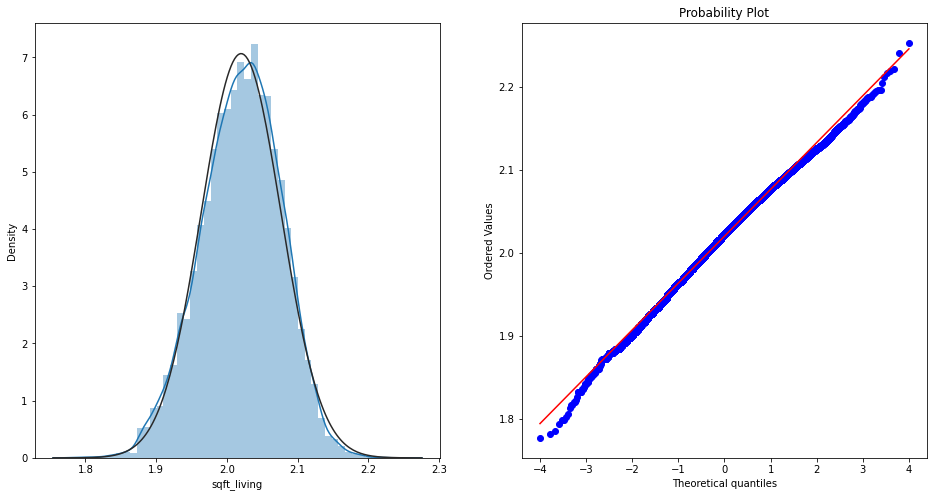

In [78]:
# create figure and axes
fig, axs = plt.subplots(1,2,figsize = (16,8))

sns.distplot(sqft_living_log_norm,fit=norm, ax=axs[0])
result = probplot(sqft_living_log_norm, plot=plt)

### Power Transformation

In [79]:
sqft_living_transformer = PowerTransformer(method="box-cox").fit(hp_df[var].to_numpy().reshape(-1,1))

sqft_living_power_norm = sqft_living_transformer.transform(hp_df[var].to_numpy().reshape(-1,1))
print(sqft_living_transformer.lambdas_)
sqft_living_power_norm = pd.DataFrame(sqft_living_power_norm)[0]

[1.15738106]


C:\Users\ehern\miniconda3\envs\DA_Environment\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


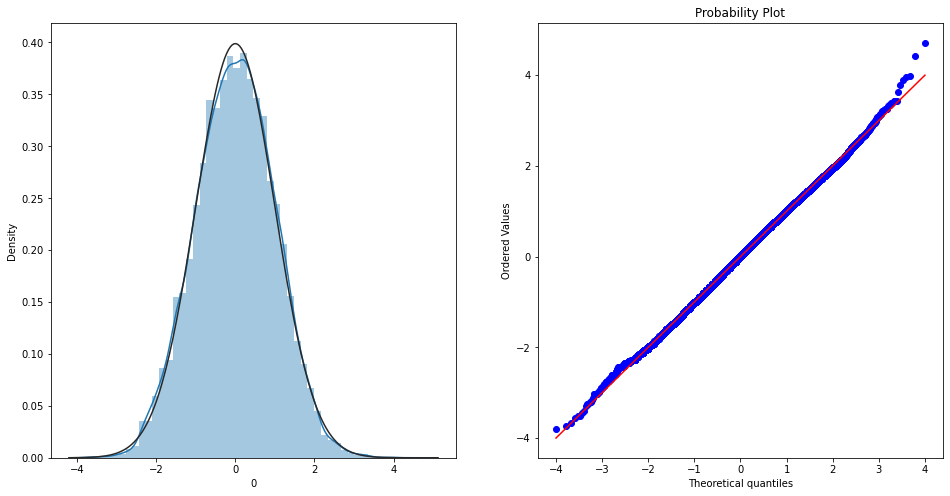

In [80]:
# create figure and axes
fig, axs = plt.subplots(1,2,figsize = (16,8))

sns.distplot(sqft_living_power_norm,fit=norm, ax=axs[0])
result = probplot(sqft_living_power_norm, plot=plt)

# sqft_living15

C:\Users\ehern\miniconda3\envs\DA_Environment\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


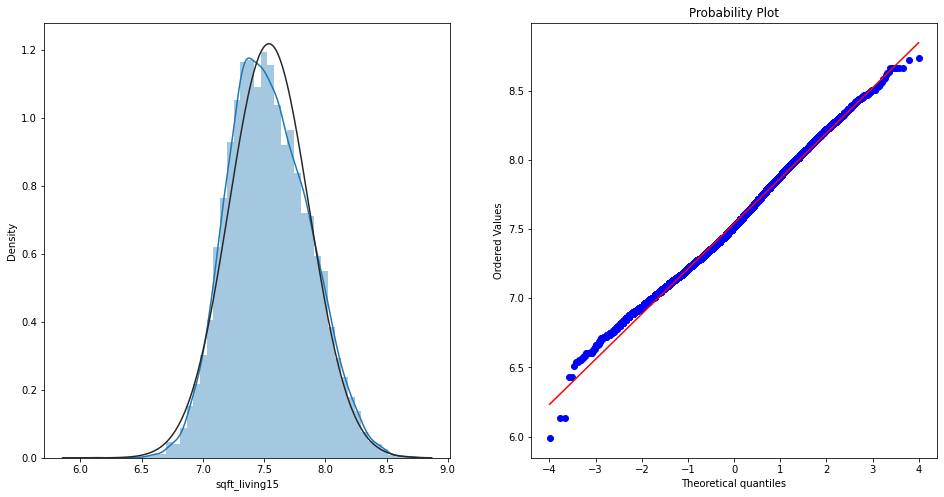

In [81]:
var = "sqft_living15"

# create figure and axes
fig, axs = plt.subplots(1,2,figsize = (16,8))

sns.distplot(hp_df[var],fit=norm, ax=axs[0])
result = probplot(hp_df[var], plot=plt)

### Logarithmic Transformation

In [82]:
sqft_living15_log_norm = np.log(hp_df[var])

C:\Users\ehern\miniconda3\envs\DA_Environment\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


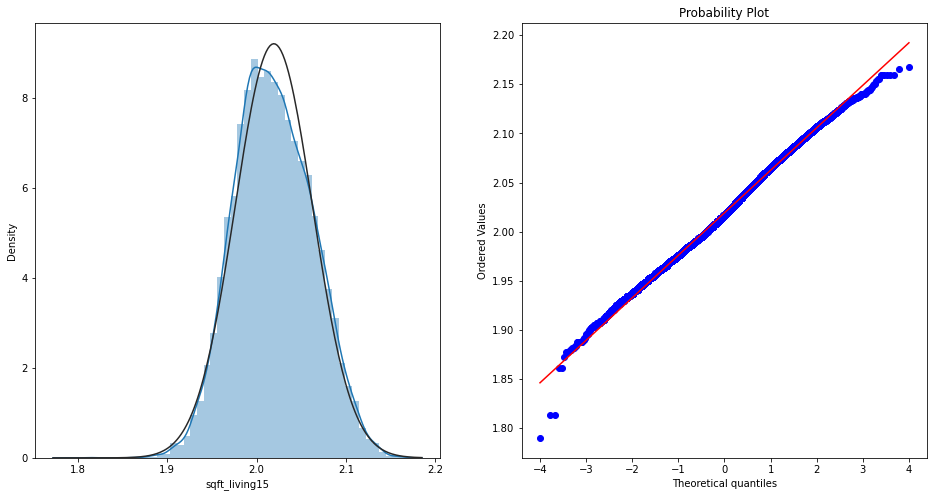

In [83]:
# create figure and axes
fig, axs = plt.subplots(1,2,figsize = (16,8))

sns.distplot(sqft_living15_log_norm,fit=norm, ax=axs[0])
result = probplot(sqft_living15_log_norm, plot=plt)

### Power Transformation

In [84]:
sqft_living15_transformer = PowerTransformer(method="box-cox").fit(hp_df[var].to_numpy().reshape(-1,1))

sqft_living15_power_norm = sqft_living15_transformer.transform(hp_df[var].to_numpy().reshape(-1,1))
print(sqft_living15_transformer.lambdas_)
sqft_living15_power_norm = pd.DataFrame(sqft_living15_power_norm)[0]

[-0.76577186]


C:\Users\ehern\miniconda3\envs\DA_Environment\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


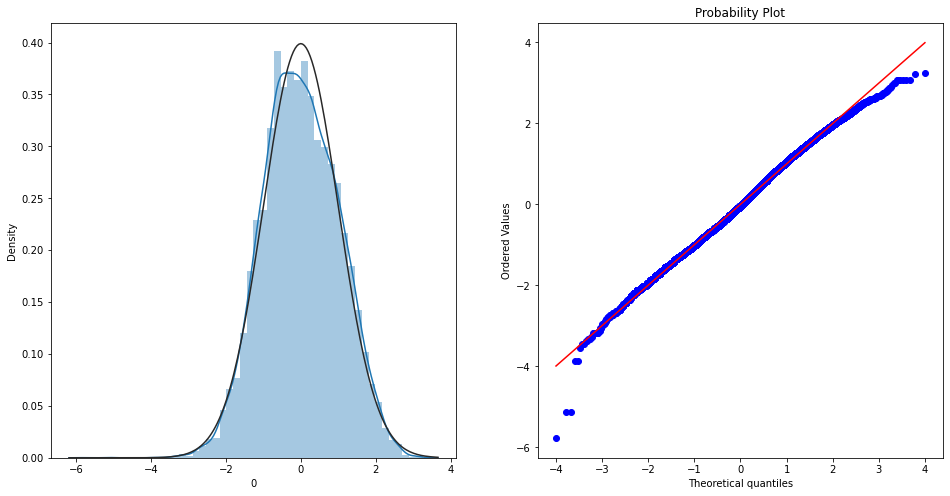

In [85]:
# create figure and axes
fig, axs = plt.subplots(1,2,figsize = (16,8))

sns.distplot(sqft_living15_power_norm,fit=norm, ax=axs[0])
result = probplot(sqft_living15_power_norm, plot=plt)

In [86]:
hp_df["price"] = price_power_norm
hp_df["sqft_living"] = sqft_living_log_norm
hp_df["sqft_living15"] = sqft_living15_log_norm

In [87]:
hp_df

,bedrooms,bathrooms,sqft_living,floors,waterfront,view,grade,age,renovated,zipcode,lat,long,sqft_living15,price
0,3,1.00,1.956323,1.0,0,0,7,60,0,98178,47.5112,-122.257,1.974140,-1.489851
1,3,2.25,2.060725,2.0,0,0,7,64,1,98125,47.7210,-122.319,2.005860,0.340940
2,2,1.00,1.894074,1.0,0,0,6,82,0,98028,47.7379,-122.233,2.067924,-1.981305
3,4,3.00,2.025606,1.0,0,0,7,50,0,98136,47.5208,-122.393,1.976195,0.553099
4,3,2.00,2.005061,1.0,0,0,8,28,0,98074,47.6168,-122.045,2.014308,0.240972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,3,2.50,1.992388,3.0,0,0,8,6,0,98103,47.6993,-122.346,1.992388,-0.442326
21593,4,2.50,2.047048,2.0,0,0,8,1,0,98146,47.5107,-122.362,2.016511,-0.229673
21594,2,0.75,1.935507,2.0,0,0,7,6,0,98144,47.5944,-122.299,1.935507,-0.219237
21595,3,2.50,1.998470,2.0,0,0,8,11,0,98027,47.5345,-122.069,1.981187,-0.229673


In [102]:
correlation_matrix = hp_df.corr()

<AxesSubplot:title={'center':'Correlation Heatmap'}>

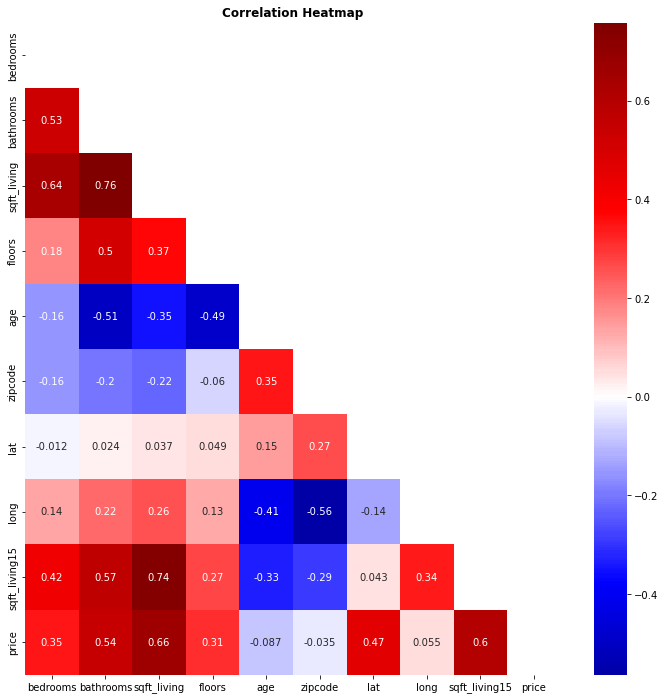

In [103]:
# Correlation Heatmap

# create figure and axes
fig, ax = plt.subplots(figsize = (12,12))

# set title
ax.set_title('Correlation Heatmap', fontweight='bold')

# mask
mask = np.zeros_like(correlation_matrix)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(correlation_matrix,  # the data for the heatmap
                          annot=True,  # show the actual values of correlation
                          cmap='seismic',  # provide the 'seismic' colormap
                          mask=mask,
                          center=0,  # specify the value at which to center the colormap
                          )

In [ ]:
hp.df.c

# Linear Regression - quick trial

In [93]:
split_scaling_encoding_output = my_transformations(hp_df, test_size=0.2, scaler="standard")

In [95]:
X_train = split_scaling_encoding_output["train"][0]
y_train = split_scaling_encoding_output["train"][2]

X_test = split_scaling_encoding_output["test"][0]
y_test = split_scaling_encoding_output["test"][2]

In [104]:
X_train

,bedrooms,bathrooms,sqft_living,floors,age,zipcode,lat,long,sqft_living15
0,0.692179,0.49184,0.874598,0.926436,-1.017420,-0.413539,-0.573493,0.178190,1.067952
1,-0.414027,0.81582,1.015566,0.926436,-0.881649,-0.057397,0.193592,1.708209,1.510882
2,-0.414027,0.16786,-0.637674,0.926436,-1.085306,-0.957123,-0.188870,1.006950,-0.883928
3,-0.414027,-0.48010,-0.096617,-0.921516,-0.304621,-0.750936,-1.081282,1.814460,-0.387906
4,-1.520233,0.49184,-0.273854,2.774387,-1.288963,0.767352,0.511231,-1.040159,-0.331720
...,...,...,...,...,...,...,...,...,...
17271,-1.520233,-0.48010,-0.994870,-0.921516,-0.508278,-0.844657,0.954916,0.199440,-0.331720
17272,-0.414027,0.16786,-1.564286,0.926436,-1.221077,0.729863,0.988768,-1.082659,-2.013405
17273,-0.414027,-0.48010,-0.612501,0.926436,0.034807,-1.032100,-1.656056,-1.139327,0.158986
17274,-0.414027,-1.45204,-1.270321,-0.921516,1.120978,0.879817,1.183961,-0.537236,-0.083763


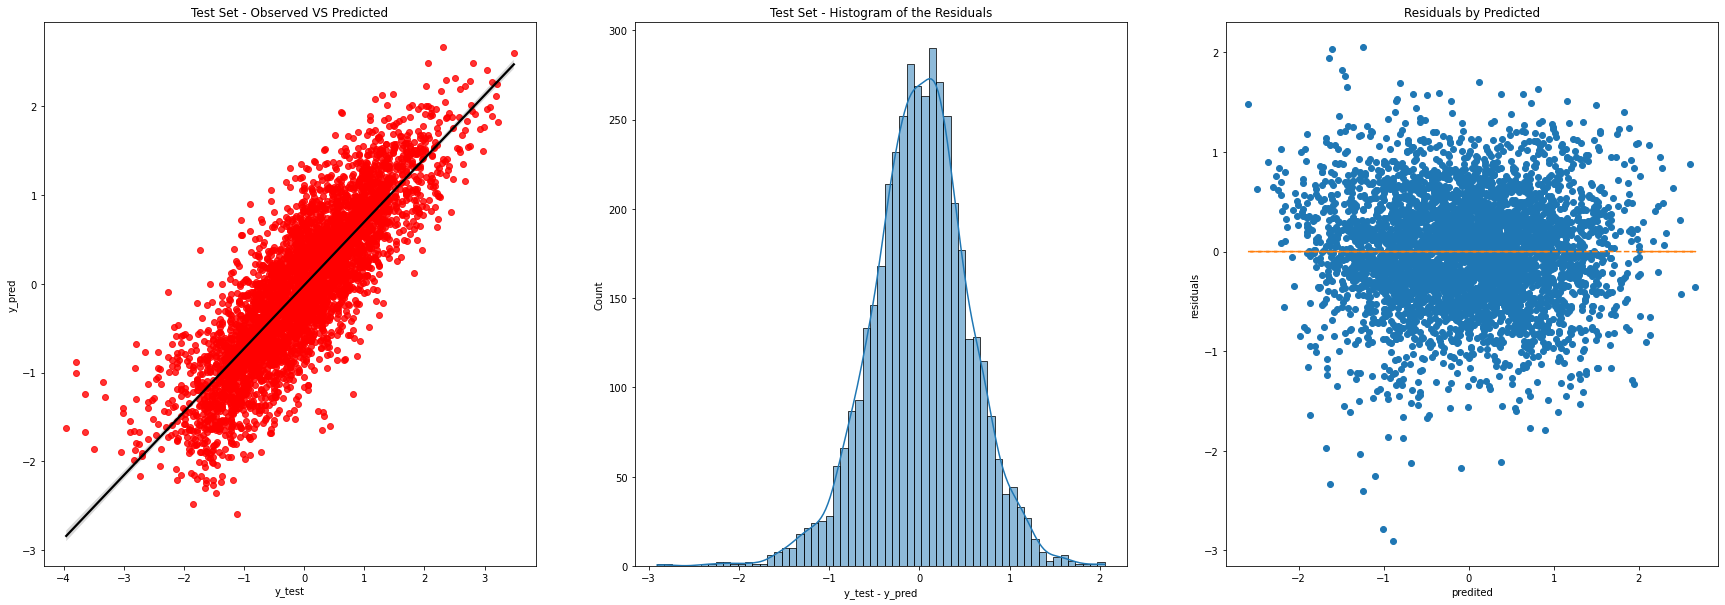

In [100]:
reg_output = my_linear_regression(X_train, y_train, X_test, y_test)

In [101]:
reg_output["Metrics"]

{'MSE': 0.294303234281388,
 'RMSE': 0.5424972205287212,
 'MAE': 0.4202131830621414,
 'R2': 0.7065559617032023,
 'R2_adj': 0.7059432015304248}